# Custom model (keras) with parallel paths

(c) Gabriel Turinici, 2024

This tutorial demonstrates training a simple custom model that uses two parallel paths, first to extract "dense" information and the other for CNN. Those are merged in the end.

We take CIFAR10 for empirical tests.

The code has been built on the canonical CNN/Tensorflow tutorial https://www.tensorflow.org/tutorials/images/cnn


### Import TensorFlow, keras etc

In [18]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, Flatten, Add, Concatenate,MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model

from sklearn.metrics import confusion_matrix
import seaborn as sns


### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [19]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


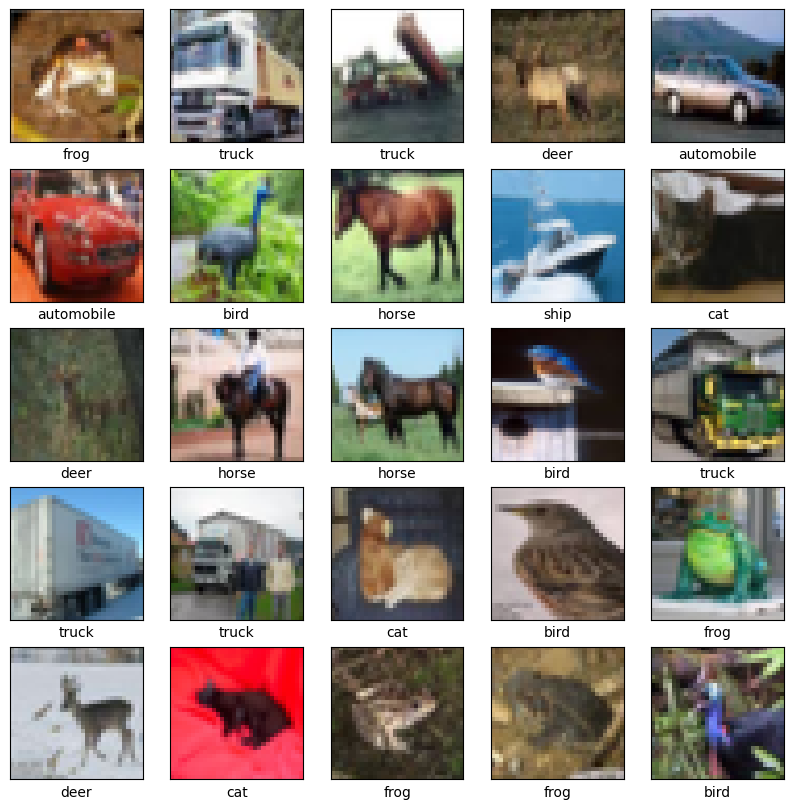

In [20]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Create the custom model

We stack [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers with FC layers. This should look like that : ![model_cnn_fc_merged.jpg]

In [21]:
def build_parallel_model(input_shape=(32, 32, 3)):
    inputs = Input(shape=input_shape)
    flat_inputs = Flatten()(inputs)

    # Parallel Path 1: Fully Connected Layers
    x_fc = Dense(8, activation='relu')(flat_inputs)
    x_fc = Dense(8, activation='relu')(x_fc)
    x_fc = Flatten()(x_fc)

    # Parallel Path 2: Convolutions with kernel size 5
    x_conv3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    x_conv3 = MaxPooling2D((2,2))(x_conv3)
    x_conv3 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(x_conv3)
    x_conv3 = MaxPooling2D((2,2))(x_conv3)
    x_conv3 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(x_conv3)

    x_conv3 = Flatten()(x_conv3) # Flatten the convolution outputs for merging

    x_conv5 = Conv2D(filters=32, kernel_size=(5,5), activation='relu', padding='same')(inputs)
    x_conv5 = MaxPooling2D((2,2))(x_conv5)
    x_conv5 = Conv2D(filters=64, kernel_size=(5,5), activation='relu', padding='same')(x_conv5)
    x_conv5 = MaxPooling2D((2,2))(x_conv5)
    x_conv5 = Conv2D(filters=64, kernel_size=(5,5), activation='relu', padding='same')(x_conv5)

    x_conv5 = Flatten()(x_conv5) # Flatten the convolution outputs for merging

    merged = Concatenate()([x_fc, x_conv3, x_conv5,flat_inputs]) # Merge all paths
    output = Dense(64, activation='relu')(merged) # Optional: Further layers after merging
    output = Dense(10)(merged) # output

    # Create the model
    model = Model(inputs=inputs, outputs=output)

    return model

# Define the input shape for your data (e.g., sequence length and features)
input_shape = (32,32,3)  # 100 time steps, 1 feature

# Build the model
model = build_parallel_model(input_shape)


Let's display the architecture of your model so far:

In [22]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 32)     │            896 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 32, 32, 32)     │          2,432 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 16, 16, 32)     │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 16, 16, 32)     │              0 │ conv2d_10[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_7 (Flatten)       │ (None, 3072)           │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 16, 16, 64)     │         51,264 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 8)              │         24,584 │ flatten_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 8, 8, 64)       │              0 │ conv2d_8[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 8, 8, 64)       │              0 │ conv2d_11[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 8)              │             72 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 64)       │         36,928 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 8, 8, 64)       │        102,464 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_8 (Flatten)       │ (None, 8)              │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_9 (Flatten)       │ (None, 4096)           │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_10 (Flatten)      │ (None, 4096)           │              0 │ conv2d_12[0][0]        │
├──────────────────────

 Total params: 349,866 (1.33 MB)

 Trainable params: 349,866 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

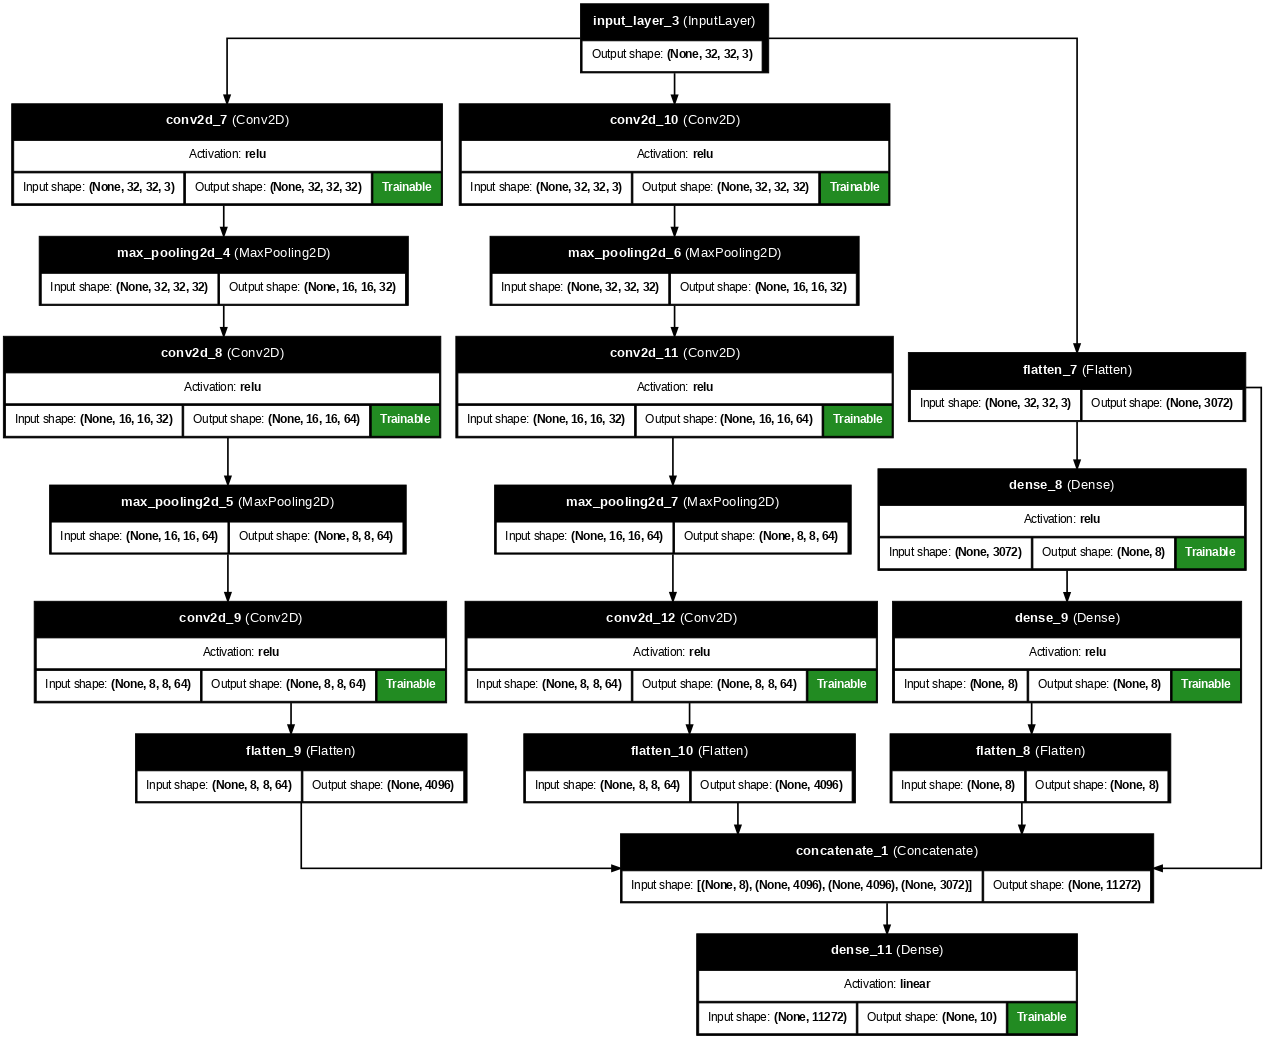

In [23]:
# Assuming 'model' is your Keras model
plot_model(model, to_file='model_plot.png', show_shapes=True,
           show_layer_names=True,show_layer_activations=True,
    show_trainable=True,dpi=60)

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

### Compile and train the model

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.3798 - loss: 1.7606 - val_accuracy: 0.5884 - val_loss: 1.2068
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6102 - loss: 1.1284 - val_accuracy: 0.6605 - val_loss: 0.9827
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6762 - loss: 0.9446 - val_accuracy: 0.6739 - val_loss: 0.9777
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7183 - loss: 0.8229 - val_accuracy: 0.6972 - val_loss: 0.9508
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7547 - loss: 0.7150 - val_accuracy: 0.7025 - val_loss: 0.9437
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7814 - loss: 0.6434 - val_accuracy: 0.7254 - val_loss: 0.8917
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8116 - loss: 0.5481 - val_accuracy: 0.7096 - val_loss: 1.0051
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8332 - loss: 0.481

### Evaluate the model

313/313 - 1s - 2ms/step - accuracy: 0.7129 - loss: 1.2079


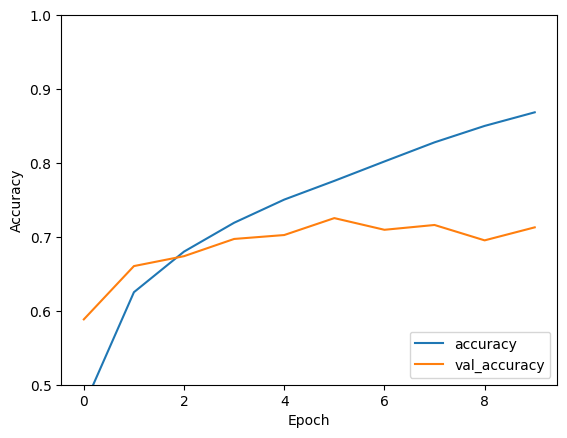

In [25]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [26]:
print(test_acc)

0.7128999829292297


Your simple CNN has achieved a test accuracy of ~ 70%. Not bad !